Connected to MySQL database
       match_id     team opposite_team        player overs runs wickets  \
0    T20I # 468  England      Pakistan  Reece Topley     4   24       3   
1    T20I # 453  England     Australia  Reece Topley     4   35       1   
2    T20I # 540  England  South Africa  Reece Topley     2   33       0   
3    T20I # 537  England   West Indies  Reece Topley   2.1   22       1   
4    T20I # 506  England  South Africa  Reece Topley     2   32       0   
..          ...      ...           ...           ...   ...  ...     ...   
92  T20I # 2402  England   West Indies   Rehan Ahmed     4   47       1   
93  T20I # 2397  England   West Indies   Rehan Ahmed     4   39       3   
94  T20I # 2232  England   New Zealand   Rehan Ahmed     4   27       2   
95  T20I # 2026  England    Bangladesh   Rehan Ahmed     3   26       0   
96  T20I # 2023  England    Bangladesh   Rehan Ahmed     2   11       1   

   economy_rate dot        ground          date  
0          6.00  13  

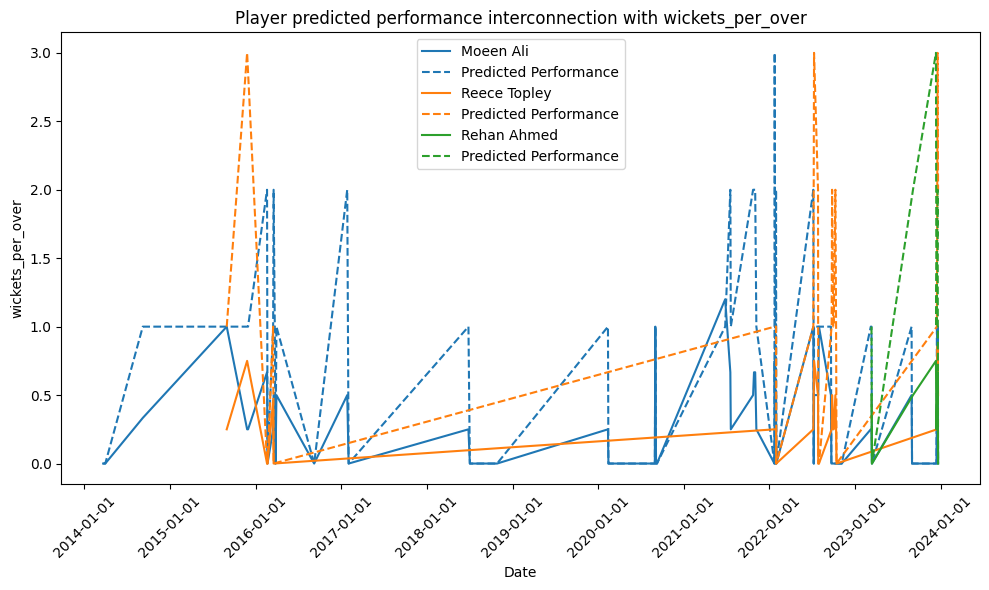

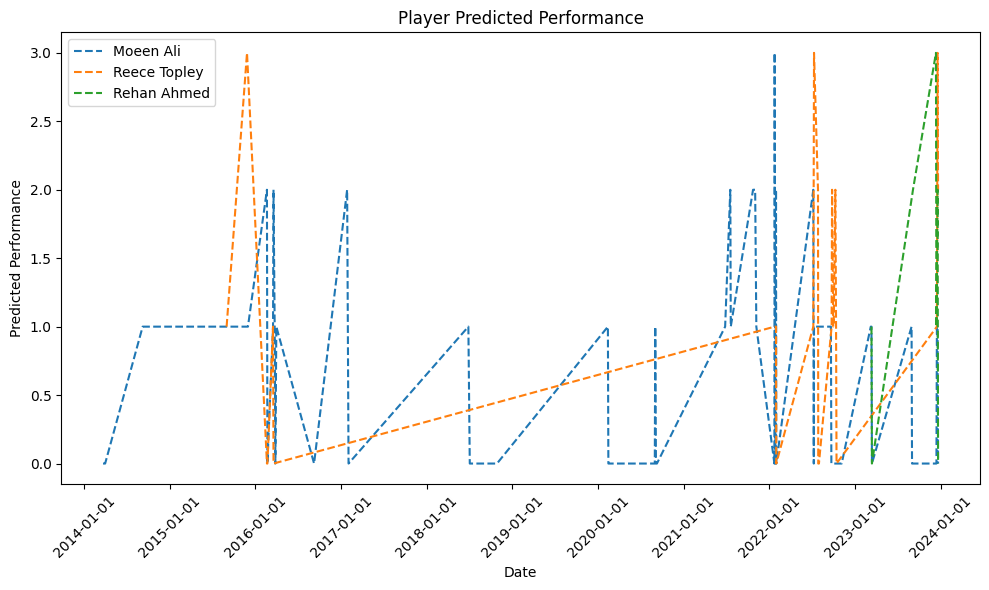

In [49]:
import mysql_connection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt

def fetch_data(team, players):
    connection = mysql_connection.get_mysql_connection()

    if connection:
        dfs = []

        for player in players:
            if team == 'All' and player == 'All':
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.runs, b.wickets, b.economy_rate, b.dot, m.ground, m.match_date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id;
                """
                cursor = connection.cursor()
                cursor.execute(sql_query)
            elif team == 'All':
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.runs, b.wickets, b.economy_rate, b.dot, m.ground, m.match_date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id
                WHERE b.player LIKE %s;
                """
                cursor = connection.cursor()
                cursor.execute(sql_query, (f'%{player}%',))
            else:
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.runs, b.wickets, b.economy_rate, b.dot, m.ground, m.match_date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id
                WHERE b.team = %s AND b.player LIKE %s;
                """
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, f'%{player}%'))

           
            rows = cursor.fetchall()
            df = pd.DataFrame(rows, columns=['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'wickets', 'economy_rate', 'dot', 'ground', 'date'])
            dfs.append(df)
            cursor.close()

        connection.close()
        df = pd.concat(dfs, ignore_index=True)
        return df
    else:
        print("Connection to the database failed.")
        return None


# Function to convert string representation of overs to decimal
def convert_to_decimal(overs_str):
    if '.' in overs_str:
        overs, balls = overs_str.split('.')
        decimal_overs = float(overs) + float(balls) / 6
    else:
        decimal_overs = float(overs_str)
    return decimal_overs


# Function to calculate Bowling Average
def calculate_bowling_average(runs, wickets):
    if wickets == 0:
        return 0
    else:
        return runs / wickets


# Function to calculate Economy Rate
def calculate_economy_rate(runs, overs):
    if overs == 0:
        return 0
    else:
        return runs / overs


# Function to calculate Strike Rate
def calculate_strike_rate(overs, wickets):
    if wickets == 0:
        return 0
    else:
        return (overs * 6) / wickets


# Function to calculate Wicket-taking Ability (Wickets per Match)
def calculate_wickets_per_match(wickets, matches):
    if wickets == 0:
        return 0
    else:
        return wickets / matches


# Function to calculate Wicket-taking Ability (Wickets per Over)
def calculate_wickets_per_over(wickets, overs):
    if wickets == 0:
        return 0
    else:
        return wickets / overs
    
def calculate_dots_per_over(dot, overs):
    if dot == 0:
        return 0
    else:
        return dot / overs
    

def transform_data(df):
    # Your transform_data function remains the same, except the preprocessing part...

    # Preprocessing part starts here...
    df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y', errors='coerce')
    df['runs'] = df['runs'].astype(float)
    df['overs'] = df['overs'].apply(convert_to_decimal)
    df['wickets'] = df['wickets'].astype(float)
    df['dot'].replace('-', np.nan, inplace=True)
    df['dot'] = pd.to_numeric(df['dot'], errors='coerce')
    df['dot'].fillna(0, inplace=True)
    df['dot'] = df['dot'].astype(float)

    df['bowling_average'] = df.apply(lambda row: calculate_bowling_average(row['runs'], row['wickets']), axis=1)
    df['economy_rate'] = df.apply(lambda row: calculate_economy_rate(row['runs'], row['overs']), axis=1)
    df['strike_rate'] = df.apply(lambda row: calculate_strike_rate(row['overs'], row['wickets']), axis=1)
    df['wickets_per_over'] = df.apply(lambda row: calculate_wickets_per_over(row['wickets'], row['overs']), axis=1)
    df['dots_per_over'] = df.apply(lambda row: calculate_dots_per_over(row['dot'], row['overs']), axis=1)

    try:
        df['day'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
    except ValueError:
        print("Dropping records with incorrect date format...")
        wrong_date_indices = df.index[(df['date'].dt.day.isna()) | (df['date'].dt.month.isna()) | (df['date'].dt.year.isna())]
        df.drop(wrong_date_indices, inplace=True)
        print(f"Dropped {len(wrong_date_indices)} records.")

    return df


def plot_performance(plot_data_df, filter_field):
    # Ensure filter_field is valid
    if filter_field not in plot_data_df.columns:
        print(f"Error: '{filter_field}' is not a valid field.")
        return

    # Sort the DataFrame by date
    plot_data_df = plot_data_df.sort_values(by='date')

    # Plot the performance for each player on a single graph
    plt.figure(figsize=(10, 6))

    for player in plot_data_df['player'].unique():
        player_records = plot_data_df[plot_data_df['player'] == player]
        plt.plot(player_records['date'], player_records[filter_field], label=player)
        plt.plot(player_records['date'], player_records['predicted_performance'], linestyle='--', color=plt.gca().lines[-1].get_color(), label='Predicted Performance')

    plt.xlabel('Date')
    plt.ylabel(filter_field)
    plt.title(f"Player predicted performance interconnection with {filter_field}")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    
    # Save the figure with the specified title
    plt.savefig(f"Player_predicted_performance_interconnection_with_{filter_field}.png")
    
    plt.show()


def plot_performance_chart_only(plot_data_df):
    # Sort the DataFrame by date
    plot_data_df = plot_data_df.sort_values(by='date')

    # Plot the predicted performance for each player on a single graph
    plt.figure(figsize=(10, 6))

    for player in plot_data_df['player'].unique():
        player_records = plot_data_df[plot_data_df['player'] == player]
        plt.plot(player_records['date'], player_records['predicted_performance'], linestyle='--', label=player)

    plt.xlabel('Date')
    plt.ylabel('Predicted Performance')
    plt.title("Player Predicted Performance")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    
    # Save the figure with the specified title
    plt.savefig("Player_predicted_performance.png")
    
    plt.show()




if __name__ == "__main__":
    team = 'England'
    players = ['Reece Topley', 'Moeen Ali', 'Rehan Ahmed']
    # players = ['Binura Fernando', 'Dushmantha Chameera', 'Lahiru Kumara', 'Chamika Karunaratne', 'Nuwan Thushara', 'Dasun Shanaka']
    filter_fields = 'wickets_per_over'
    # filter_fields = ['economy_rate', 'bowling_average', 'strike_rate', 'wickets_per_over', 'dots_per_over']
    
    df = fetch_data(team, players)
    print(df)
    player_data_processed = transform_data(df)
    print(player_data_processed)

    # Load the trained Gradient Boosting Regression model
    gradient_boosting_model = joblib.load("gradient_boosting_model_for_bowling.pkl")
    
    # Filter the data for the given list of players
    selected_players_data = player_data_processed[player_data_processed['player'].isin(players)]
    
    # Extract features for the selected players
    selected_players_features = selected_players_data[['team', 'opposite_team', 'overs', 'runs', 'wickets', 'economy_rate', 'dot', 'ground', 'day', 'month', 'year', 'bowling_average', 'strike_rate', 'wickets_per_over', 'dots_per_over']]
    
    # Predict the performance of each player
    player_predictions = gradient_boosting_model.predict(selected_players_features)
    
    # Combine player names with their predicted performance
    player_performance = pd.DataFrame({'Player': selected_players_data['player'], 'Predicted Performance': player_predictions})
    
    # Rank players based on predicted performance
    ranked_players = player_performance.sort_values(by='Predicted Performance', ascending=False)
    
    # Present the ranked list of players to the user
    print("Ranked Players based on Predicted Performance:")
    print(ranked_players)



    # -----data grape------------
    # Create a DataFrame with the specified fields
    plot_data = {
        'player': player_data_processed['player'],
        'date': player_data_processed['date'],
        'economy_rate': player_data_processed['economy_rate'],
        'bowling_average': player_data_processed['bowling_average'],
        'strike_rate': player_data_processed['strike_rate'],
        'wickets_per_over': player_data_processed['wickets_per_over'],
        'dots_per_over': player_data_processed['dots_per_over'],
        'predicted_performance': ranked_players['Predicted Performance']  # Assuming predictions contain the predicted performance for each player
    }
    
    plot_data_df = pd.DataFrame(plot_data)
    print(plot_data_df)

    plot_performance(plot_data_df, filter_fields)

    plot_performance_chart_only(plot_data_df)